# The FFT algorithm

## Direct DFT
The fourier transofrm of a function $f(x)$ is the function $F(\omega)$ defined as:

$$F(\omega)=\int_{-\infty}^{\infty}f(x)e^{i\omega x}dx $$

with inverse Fourier transofrm defined as:

$$f(x)=\frac{1}{2\pi}\int_{-\infty}^{\infty}F(\omega)e^{i\omega x}d\omega. $$

When working with digital audio, the object of the examination is not a continuous wave but a discrete sequence of PCM samples that represent, digitally, air pressure in the domain of time. This brings us to the _discrete_ version of the fourier transform:

$$ X_k=\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}kn}.$$

This is often written as

$$X_k=\sum_{n=0}^{N-1}x_nW^{kn}_{N}$$

where $ W_{N} = e^{-i\frac{2\pi}{N}}$ is often referred to as _twiddle factor_ and refers to the $N-th$ roots of the unit circle of the complex plane. These factors can be interpreted as different "rotations" of the input numbers around the complex circle.

This transformation, in particular, accepts as  input a vector of $N$ numbers (in our case, audio samples) $x_n$ for $n=0,\ldots,N-1$ and outputs a vector of $N$ complex numbers $X_n$ that represent the frequency components of the signal represented by the samples in input. The $N$ complex numbers represent $N$ _frequency bins_ that divide the frequency space in $N$ intervals. 

The real part of each $X_n$ represents the _magnitude_ of the associated frequency bin, while the imaginary part represents the _phase_ of that frequency component. The magnitude and phase togheter are sufficient to represent the whole waveform. 

Since discrete fourier assumes periodicity, we can assume that $x_n=x_{n=jN}$ for all $n$ and $j$.The fact that the discrete fourier transform assumes periodicity will be tackled further on this discussion and will be the main reason behind the _windowing_ of the audio signal.

Let us now take into consideration an example with $N=4$. Our input will be given by the one dimensional vector $[ x_0,x_1,x_2,x_3]$ and we will have
$$W_4=e^{-i\frac{2\pi}{4}}=-i$$
so our summation will be:
$$ X_k=\sum_{n=0}^3(-i)^{kn}x_n=(-i)^{0}x_0+(-i)^{k}x_1+(-i)^{2k}x_2+(-i)^{3k}x_3$$
which is equal to 
$$ x_0+(-i)^kx_1+(-1)^kx_2+i^kx_3.$$

Our complete dicrete Fourier transform will then be:
$$\begin{align*}
&X_0=x_0+x_1+x_2+x_3\\
&X_1=x_0-ix_1-x_2+x_3\\
&X_2=x_0-x_1-x_2-x_3\\
&X_3=x_0+ix_1-x_2-ix_3.\\
\end{align*}$$

This operation is a complex multiply-add whose complexity can be better visualized if we represent it as a matrix multiplication between a matrix of twiddle factors and a column vector of input numbers.

$$
\mathbf{X}=\begin{bmatrix}X_0\\
X_1\\
X_2\\
X_3\\\end{bmatrix}=\begin{bmatrix}
W_4^{0\cdot 0} & W_4^{0\cdot 1} & W_4^{0\cdot 2} & W_4^{0 \cdot 3} \\
W_4^{1\cdot 0} & W_4^{1\cdot 1} & W_4^{1\cdot 2} & W_4^{1 \cdot 3} \\
W_4^{2\cdot 0} & W_4^{2\cdot 1} & W_4^{2\cdot 2} & W_4^{2 \cdot 3} \\
W_4^{3\cdot 0} & W_4^{3\cdot 1} & W_4^{3\cdot 2} & W_4^{3 \cdot 3} \\ 
\end{bmatrix}\begin{bmatrix}
x_0\\
x_1\\
x_2\\
x_3\\
\end{bmatrix}.
$$

It is evident how in this setting we must calculate, on top of the matrix multiplication, $N\times N$ twiddle factors. This hints to a $\mathcal{O}(N^2)$ complexity of this algorithm.

We start by implementing this "direct" DFT function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

def direct_dft(x):
    #number of numbers in input
    N = len(x)
    #array of numbers from 0 to N-1
    n = list(range(0,N)) 
    #"vertical" array of numbers from 0 to N-1 (actually a list of lists)
    k = [[item] for item in n] 

    #matrix of zeroes to populate with twiddle factors
    M = [[0 for col in range(N)] for row in range(N)] 
    #proceed to populate the twiddle factor matrix
    for i in range(N):
        for j in range(N):
            M[i][j]=np.exp(-2j*np.pi*i*j/N)

    #initialize result vector
    res = [0 for item in range(N)]
    #perform "reduced" matrix multiplication (since we know the second matrix is Nx1)
    for i in range (N):
        for j in range(N):
            res[i] += M[i][j] * x[j]
    return res

We can now test this function:

In [29]:
direct_dft([1,2,3,4,5,6,7,8])

[np.complex128(36+0j),
 np.complex128(-4.000000000000003+9.65685424949238j),
 np.complex128(-4.000000000000002+3.9999999999999982j),
 np.complex128(-4+1.656854249492386j),
 np.complex128(-4-3.91886975727153e-15j),
 np.complex128(-4.0000000000000115-1.6568542494923912j),
 np.complex128(-4.000000000000018-4.000000000000005j),
 np.complex128(-3.9999999999999725-9.656854249492369j)]

It is worth noting that, instead of dealing with nested loops to compute matrix operation, we can create a more efficient version of this algorithm by taking advantage of the better optimized operations present in the library `numpy`:

In [30]:
def np_dft(x):
    #transform the input in a np.array tpe
    x = np.asarray(x, dtype=float) 
    #obtain the number of samples (dimension of the array)
    N = x.shape[0]
    #create a sequence of integers from 0 to N-1
    n = np.arange(N)
    #reshape the sequence in a vertical array
    k = n.reshape((N, 1)) 
    #create and populate the 4x4 twiddle factor matrix
    M = np.exp(-2j * np.pi * k * n / N)
    #perform a matrix multiplication between the twiddle factor matrix and the input
    return np.dot(M, x)

In [31]:
np_dft([1,2,3,4,5,6,7,8])

array([36.+0.00000000e+00j, -4.+9.65685425e+00j, -4.+4.00000000e+00j,
       -4.+1.65685425e+00j, -4.-3.91886976e-15j, -4.-1.65685425e+00j,
       -4.-4.00000000e+00j, -4.-9.65685425e+00j])

As we can see, the two functions bear the same result (with room for different approximations).

# Fast Fourier Transform Algoritms
If we get back to the previous example of $N=4$, we see that 

$$\begin{align*}
&X_0=x_0+x_1+x_2+x_3\\
&X_1=x_0-ix_1-x_2+x_3\\
&X_2=x_0-x_1-x_2-x_3\\
&X_3=x_0+ix_1-x_2-ix_3\\
\end{align*}$$

can be rewritten as

$$\begin{align*}
&X_0=(x_0+x_2)+(x_1+x_3)\\
&X_1=(x_0-x_2)-i(x_1-x_3)\\
&X_2=(x_0+x_2)-(x_1+x_3)\\
&X_3=(x_0-x_2)+i(x_1-x_3).\\
\end{align*}$$

We can already catch on some patterns: we note that the even and odd elements of the transformed sequence $X_n$ are respectively composed by the same pairs of numbers with the same twiddle factors and only differ for the sign in between the two pairs of numbers.

We can express these complex computations via butterfly operations.

INSERIRE TIKZ DEI BUTTERFLY

More formally, we can come to the general conclusion
$$ \begin{align*}
X_k &=\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}kn}\\
&=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{N}k(2n)}+\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{N}k(2n+1)}\\
&=\underbrace{\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}kn}}_{\text{DFT of even indices of }x_n}+e^{-i\frac{2\pi}{N}k}\cdot\underbrace{\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}kn}}_{\text{DFT of odd indices of }x_n}\\
&=\text{evenFFT}_k+e^{-i\frac{2\pi}{N}k}\cdot \text{oddFFT}_k.
\end{align*}
$$ 
The FFT of $x_n$ can be expressed as the combination of a FFT performed on the $x_n$ with _even_ indices and a FFT performed on the $x_n$ with _odd_ indices. If we further consider the transformed element $X_{k+\frac{N}{2}}$, we obtain:

$$
\begin{align*}
X_{k+\frac{N}{2}} &=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}(k+\frac{N}{2})n}+e^{-i\frac{2\pi}{N}(k+\frac{N}{2})}\cdot\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}(k+\frac{N}{2})n}\\
&=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}kn}e^{-2i\pi n}+e^{-i\frac{2\pi}{N}k}e^{-i\pi}\cdot\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}kn}e^{-2i\pi n}\\
\end{align*}
$$
but using Euler's formula we get 
$$
\begin{align*}
&e^{-2i\pi n}=1\\
&e^{-i\pi}=-1
\end{align*}
$$
so
$$
\begin{align*}
X_{k+\frac{N}{2}} &=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}kn}-e^{-i\frac{2\pi}{N}k}\cdot\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}kn} \\
&=\text{evenFFT}_k-e^{-i\frac{2\pi}{N}k}\cdot \text{oddFFT}_k.
\end{align*}
$$
Referring to our example with $N=4$ we now see how this applies to $X_{0}, X_{0+2=2}$ and $X_{1}, X_{1+2=3}$ respectively. A step further may be in applying the same procedure to the new 2 FFTs performed on the even and odd indices: this leads us to the recursive solution for the FFT algorithm.

## Recursive Decimation-in-time FFT Algorithm
If $N$ is a power of 2, we can apply a so-called _radix-2 decimation-in-time algorithm_ (DITFFT). This is the most straightforward and intuitive implementation of the FFT algorithm. In this classic "divide-and-conquer" algorithm we half the size of the problem with each level, so we end up with $\log_2(N)$ levels of recursion with the base case being $N=1$ (the DFT of a single number is trivial, bearing the number itself). At each level, the operation consists in combining the results through the _butterfly operations_, which is a simple add/multiply with complexity $\mathcal{O}(N)$. This hints to a $\mathcal{O}(N\log(N))$ complexity in this recursive algorithm.

We now implement the algorithm and test it against the direct one.

In [32]:
def recursive_FFT(x):
    N = len(x)
    #base case
    if N == 1: 
        return x
    if N % 2 > 0:
        raise ValueError("input lenght must be a power of 2")
    #recursive call: split the input in the even/odd part and call the function again
    even = recursive_FFT(x[::2])
    odd =  recursive_FFT(x[1::2])
    r = range(N//2)
    #calculate twiddle factors multiplied for the odd part
    oddtwiddle = [np.exp(-2j * np.pi * k / N) * odd[k] for k in r]
    #concatenating the X_k component with the X_{k+N/2} component using list comprehension syntax
    res = ([even[k] + oddtwiddle[k] for k in r] + [even[k] - oddtwiddle[k] for k in r])
    return res


We can test this algorithm and see that it returns the same result of the ```direct_DFT()``` function:

In [33]:
recursive_FFT([1,2,3,4,5,6,7,8])

[np.complex128(36+0j),
 np.complex128(-4+9.65685424949238j),
 np.complex128(-4+4j),
 np.complex128(-4+1.6568542494923797j),
 np.complex128(-4+0j),
 np.complex128(-4-1.6568542494923806j),
 np.complex128(-3.9999999999999996-4j),
 np.complex128(-3.9999999999999987-9.65685424949238j)]

In [34]:
direct_dft([1,2,3,4,5,6,7,8])

[np.complex128(36+0j),
 np.complex128(-4.000000000000003+9.65685424949238j),
 np.complex128(-4.000000000000002+3.9999999999999982j),
 np.complex128(-4+1.656854249492386j),
 np.complex128(-4-3.91886975727153e-15j),
 np.complex128(-4.0000000000000115-1.6568542494923912j),
 np.complex128(-4.000000000000018-4.000000000000005j),
 np.complex128(-3.9999999999999725-9.656854249492369j)]

We can use the Python magic function `%timeit` to calculate the speed of the two different functions:

In [35]:
%timeit recursive_FFT([1,2,3,4,5,6,7,8])
%timeit direct_dft([1,2,3,4,5,6,7,8])

24.5 μs ± 784 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
93.5 μs ± 2.05 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


As we can see, for $N=8$ the FFT function is slightly faster. An interesting fact is that for a small input vector N, the advantages of $N log(N)$ complexity against $N^2$ are not extremely visible: in fact, the direct DFT function made with the optimized numpy operations may even outrun the FFT function for such a small $N$.

In [36]:
%timeit recursive_FFT([1,2,3,4,5,6,7,8])
%timeit np_dft([1,2,3,4,5,6,7,8])

24.2 μs ± 451 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
14.8 μs ± 380 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Of course, the power of linearithmic complexity appears for very large $N$ sizes. Let's try with $2^{15}=32768$ random numbers.

In [37]:
np.random.seed(2024)
signal=np.random.rand(1,32768)*10

%timeit recursive_FFT(signal)
%timeit direct_dft(signal)
%timeit np_dft(signal)         


106 ns ± 5.85 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
544 μs ± 37.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.15 ms ± 521 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As we can see, the FFT algorithm outperforms both of the direct DFT methods by orders of magnitude. 

We can further test this function for its intended purpose by creating a series of samples from an harmonic signal and feed it into the FFT algorithm. Using the library `matplotlib` we can also visualize the signal as a graph of samples in the time domain. We start with a simple sine wave with added harmonics (i.e. multiplies of the base fequency)

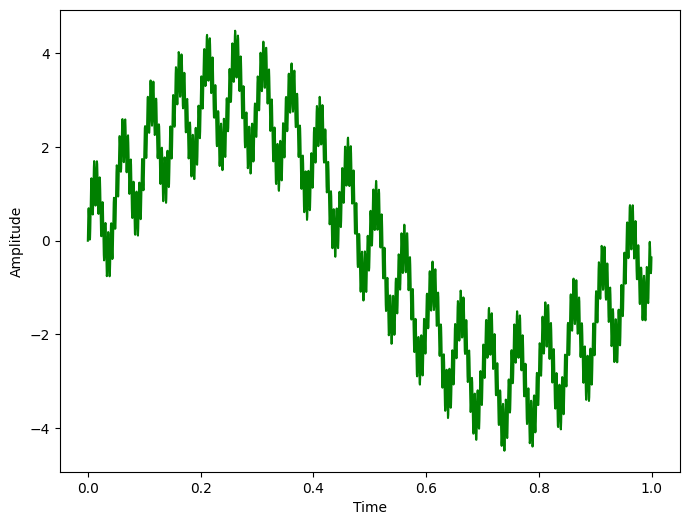

In [38]:
# define the number of samples (sampling rate)
samps = 2048
# define the sample interval: 1 second/samps per second
interval = 1.0/samps
t = np.arange(0,1,interval)

# set base frequency 1
additive_wave = 3*np.sin(2*np.pi*1.*t)

# add 20nd harmonic
additive_wave += np.sin(2*np.pi*20.*t)

# add 200th harmonic
additive_wave += 0.5* np.sin(2*np.pi*200.*t)

plt.figure(figsize = (8, 6))
plt.plot(t, additive_wave, 'g')
plt.ylabel('Amplitude')
plt.xlabel('Time')

plt.show()

Here we chose to represent our curve with 2048 points per second. According to the Nyquist-Shannon sampling theorem, this only allows us to represent frequencies up to $\frac{1}{2}$ the sampling frequency (in our case $2048/2=1024$). This threshold is called the _Nyquist frequency_. 

It is important to remind that the transformed sequence X is a sequence of complex numbers with an imaginary part (representing the phase of the corresponding frequency) and a real part (representing the magnitude of the corresponding freqeuncy). In order for these numbers to be represented on a spectrogram, it is necessary to take the absolute value of the transformed frequency and ditch the imaginary part, since spectrograms do not contain information about the phase.

Another issue worth addressing when analyzing the spectrogram of a DFT of a fully real input (like a sequence of PCM samples) is the evident "mirroring" of the frequencies around the Nyquist frequency. This is due to the nature itself of the DFT of a real, which is __conjugate symmetric__. Consider the $k-th$ bin of the transformed sequence, with $1\leqslant k\leqslant N-1$
$$ X_k =\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}kn}$$
And the $(N-k)-th$ bin 
$$
\begin{align*}
X_{N-k}&=\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}(N-k)n}\\
&=\sum_{n=0}^{N-1}x_ne^{(-i2\pi+i\frac{2\pi}{N}k)n}\\
&=\sum_{n=0}^{N-1}x_ne^{+i\frac{2\pi}{N}kn}\\
\end{align*}
$$
Consider now the complex conjugate of $X_k$, $(X_k)^*$:
$$
\begin{align*}
(X_k)^*&=\left(\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}kn}\right)^*\\
&=\sum_{n=0}^{N-1}(x_n)^*e^{+i\frac{2\pi}{N}kn}
\end{align*}
$$
but since $x_n$ is real and therefore has no imaginary part, we have that $(x_n)^*=x_n$ and so
$$
\begin{align*}
(X_k)^*&=\sum_{n=0}^{N-1}x_ne^{+i\frac{2\pi}{N}kn}\\
&=X_{N-k}.
\end{align*}
$$
The fact that $X_{N-k}=(X_k)^*$ has the important consequence that the real parts of $X_{N-k}$ and $X_k$ are identical, while their imaginary parts have the same maginitude but opposite signs. An interesting interpretation of this fact lies in the observations that the parts with negative imaginary part (which corresponds to a _negative phase_) are _negative frequencies_, that "spin" in the opposite direction of the positive frequency. 

This fact has, of course, little application in the practice of digital signal processing and this is why the negative frequencies produced by the DFT are usually ditched.

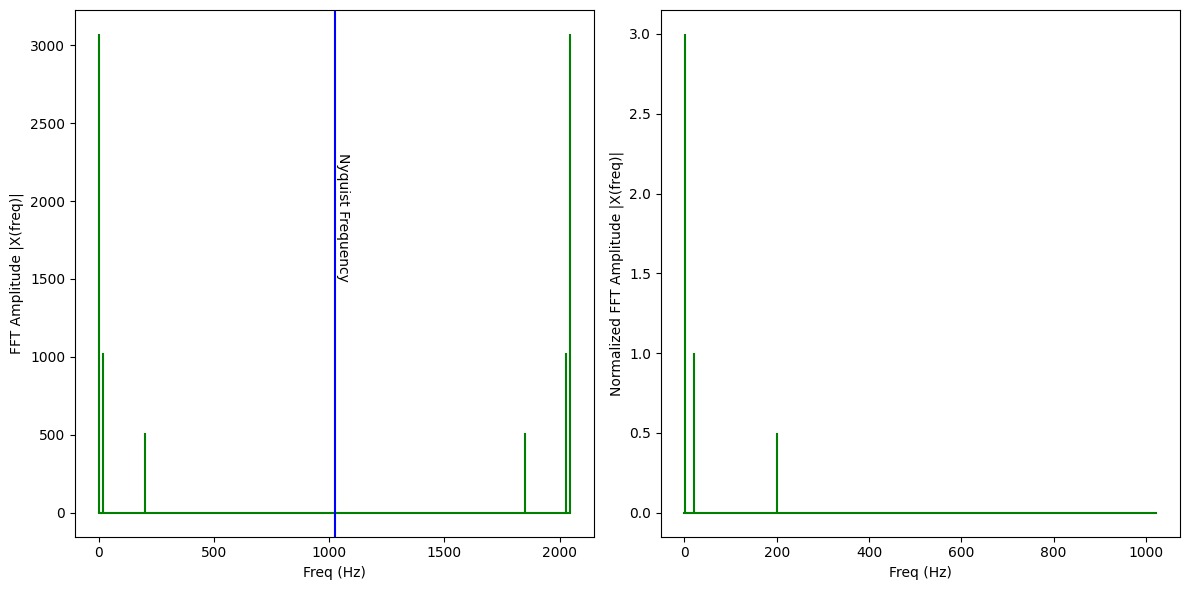

In [39]:
X=recursive_FFT(additive_wave)
X = np.array(X)
# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/samps
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, np.abs(X), 'g',  markerfmt=" ", basefmt="-g")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.axvline(x = 1024, color = 'b')
plt.text(1030,1500,'Nyquist Frequency',rotation=270)
# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.subplot(122)
plt.stem(f_oneside, np.abs(X_oneside), 'g', markerfmt=" ", basefmt="-g")
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalized FFT Amplitude |X(freq)|')
plt.tight_layout()
plt.show()

plt.show()

In these spectrograms, respectively the full one and the "one-sided" one.

There is an interesting consideration to do about the first spectrogram. According to what we saw earlier, we would expect the transformed sequence to present negative frequencies (that would be reflected in the positive domain due to the presence of the absolute value operator on the transformed sequence) but all we see is that the "true" frequencies that concur to the energy of the signal (in our case 1Hz, 20Hz and 200Hz) are mirrored towards the higher end of the spectrum around the Nyquist frequency. 
This is due to the phenomenon of aliasing: as said before, given a certain frequency of sample rate we will be able to represent only the frequencies below $\frac{1}{2}$ of the sample rate (Nyquist frequency $f_{Ny}$), since any higher frequency $f_0$ would appear, from the samples, indistinguishable ("aliased") from the frequency corresponding to $f_{Ny}-f_0$. 
This implies that high frequencies beyond the Nyquist frequency are "aliased" (and vice versa) to the negative frequencies, explaining the absence of the latter from the spectrogram.

Either way, the result is the same: negative frequencies are ditched due to their lack of usefulness in real-world application and frequencies beyond the Nyquist frequency are ditched because they are impossible to represent uniquely. One should take into account this fact when representing "one-sided" spectrogram by adjusting the energy of the real frequencies by a factor of 2 (to make up for the ditched frequencies, that in practice are identical manifestations of the real frequencies).

## A possible step further: Iterative Fast Fourier Transform Algorithm

The recursive FFT, as we saw earlier, has an arithmetic complexity of $\mathcal{O}(N \log(N))$ but, being a recursive algorithm, leads to relevant stack problems, as I experienced after trying to feed 10 billions complex numbers into the FFT algorithm causing my laptop to burn through all 32 GBs of ram and obliterating my thinkpad into eternity. The problem lies in the fact that every recursion calls the function twice and each time it stores an array of length $2^n$ $n$ times. This is due to the fact that the recursive FFT is a "out-of-place" algorithm that allocates memory for each iteration without overwriting alreay allocated memory.

A possible solution to this issue lies in a "in-place" version of the FFT algorithm that overwrites the already allocated memory stack. Let's observe how the input vector components get rearranged. The image below represents the case for an input of length 8. Note how the bottom layer shows the single input components arranged in a particular order.

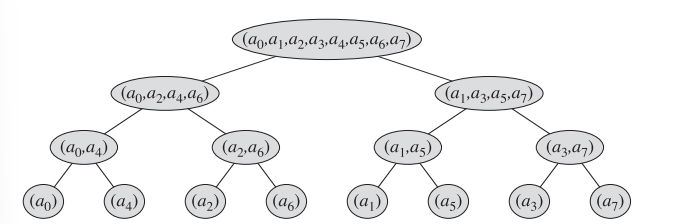

If we could arrange from the start the input components in a order that resembles the one reached by the deepest level of recursion (that is, when $N=1$), we could create a non-recursive approach for the FFT algorithm that works "bottom up". The idea behind this algorithm is the following:
1. we store in an array $A[0,\ldots,n-1]$ in the order in which they appear in the leaves of the recursion tree;
2. we take the elements in pairs, applying the butterfly operation that multiplies/adds two inputs with the twiddle factor to obtain $X_k=\text{evenFFT}_k+e^{-i\frac{2\pi}{N}k}\cdot \text{oddFFT}_k$ and $X_{k+\frac{N}{2}}=\text{evenFFT}_k-e^{-i\frac{2\pi}{N}k}\cdot \text{oddFFT}_k$. This will provide us with $N/2$ size 2 DFTs of each pair;
3. we replace the pairs in the array with their DFTs;
4. we take these $N/2$ DFTs (of size $2$ each) in pair and we compute the DFT of the $N/4$ groups of 4 input each that sit at the upper level in the recursion tree. This operation will apply two butterfly operations (since we are dealing with inputs of length 4);
5. we write these $N/4$ size 4 DFTs in the array;
6. we iterate the procedure untile the array holds 2 size $N/2$ DFTs, which we can combine using $N/2$ butterfly operations to obtain out final $N$ size DFT.

When examining the final arrangement of the array we note that the final indices are the __bit reversed__ version of the starting indices. It is easy then to create a function that, given an input array, creates a bit-reversed version.

In [40]:
def reverse(num, size):
    result = 0
    for i in range(size): #shift result to the left bitwise and add the least significant bit to result
        result = (result << 1) + (num & 1)
        num >>= 1 #shift original number to the right bitwise (until none bits are left)
    return result

def bit_reversal(lst):
    n = len(lst)
    #bit reversal depends on the size of the integer: for each index we need a number of bits equal to the number of bits used to represent the highest index
    bit_size = n.bit_length() - 1 #using int class bit_length method

    #note that the previous method for calculating the bit size only works because we expect the input to be a power of 2 and in binary powers of 2 are the numbers for which the number of bit needed for representation increases by 1. 
    # If our input wasn't strictly in powers of 2 this method wouldn't be correct (for example, if n=5 then we would get a bit size of 2, which are too few to represent the number 4).

    res = [0 for i in range(n)]
    for i in range(n):
        reversed_index = reverse(i, bit_size)
        res[reversed_index] = lst[i]

    return res


Now that we have devised a method to output a list in bit-reversed order, we can turn our attention to the iterative fft method itself. We know this is a radix-2 algorithm, so we will need to go through $\log_2(n)$ iterations.

In [41]:
def iterative_FFT(x):
    #store the array in bit reversed order
    revx=bit_reversal(x)
    n=len(revx)

    #this first loop iterates through the levels of the tree
    for i in range(1,int(math.log2(n))+1)
        #these operations ensure that the correct twiddle factor is created for each level.
        #for example, the first DFTs are, as we said before, size-2 dfts so the exponent of the twiddle factors will need to be divided by two... and so on.
        m=2**i
        twiddle_m=np.exp(2j*np.pi/m) 

        #for each level of the tree we go through the corresponding groups of inputs
        #for example, at the first level we go two by two (our DFTS are of size 2), at the second level we go four by four (our DFTs are of size 4)... and so on.
        for k in range(0,n,m):
            twiddle_single=1 #create the base twiddle factor for the lowest level butterfly operation

            #this last loop iterates through the single items of each of the groups of two/four/eight...N/2 input components
            for l in range(0,m//2):
                t = twiddle_single*revx[k+l+m//2] #butterfly operation
                u = revx[k+l]
                revx[k+l]=u+t #write the k-th transformed element
                revx[k+l+m//2]=u-t #write its sibling (k+n/2)-th transformed element.
                twiddle_single=twiddle_single*twiddle_m #update the twiddle factor
    return revx

This iterative altorithm runs in time $\Theta(N \log(N))$. It calls the function `bit_reversal()` which is also linearithmic, since it loops $n$ times a reversal of an integer of length $\log_2(n)$ We can now test the iterative algorithm against the recursive algorithm:

In [42]:
iterative_FFT([1,2,3,4,5,6,7,8]),recursive_FFT([1,2,3,4,5,6,7,8])

([36,
  np.complex128(-4-9.65685424949238j),
  np.complex128(-4-4.000000000000001j),
  np.complex128(-4-1.6568542494923815j),
  -4,
  np.complex128(-4+1.6568542494923806j),
  np.complex128(-4+4.000000000000001j),
  np.complex128(-3.999999999999999+9.656854249492381j)],
 [np.complex128(36+0j),
  np.complex128(-4+9.65685424949238j),
  np.complex128(-4+4j),
  np.complex128(-4+1.6568542494923797j),
  np.complex128(-4+0j),
  np.complex128(-4-1.6568542494923806j),
  np.complex128(-3.9999999999999996-4j),
  np.complex128(-3.9999999999999987-9.65685424949238j)])

We can also use the magic function `%timeit%` again to test the speed of the two algorithms.

In [43]:
%timeit iterative_FFT(signal)
%timeit recursive_FFT(signal)

1.1 μs ± 30.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
109 ns ± 9.77 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


As we can see, the recursive algorithm is faster. Despite both algorithm having the same complexity, the iterative one may introduce some overhead (possibly trough the bit reversal step and the nested loops).

Now that we have examined some of the most common applications of the FFT algorithm, we are ready to utilize it in our pitch shifter.

# Designing the pitch shifter

In [2]:
import librosa
import IPython.display as idisplay

In [11]:
waveform, sr = librosa.load("audio.wav", sr=44100, mono=False)
channels, og_len = waveform.shape
print(waveform.shape, sr)
idisplay.display(idisplay.Audio(waveform, rate=sr))

(2, 261684) 44100


In [12]:
def show_sgram(stft, hop_len, n_fft):
    fig, ax = plt.subplots()
    sgram = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft[0, :, :]), ref=np.max), sr=sr, hop_length=hop_len, n_fft=n_fft, win_length=win_len, x_axis="time", y_axis="linear", ax=ax)
    fig.colorbar(sgram, ax=ax, format="%+2.f dB")

In [15]:
def interpolate_time(idxs: np.ndarray, arr):
    start = (idxs + 0.5).astype(int)
    frac = (idxs - start)[None, None, :]
    shifted_arr = np.concatenate((arr[:, :, 1:], np.zeros((arr.shape[0], arr.shape[1], 1))), axis=2)
    return arr[:, :, start] * (1 - frac) + shifted_arr[:, :, start] * frac

In [ ]:
def round_interpolate_time(idxs: np.ndarray, arr):
    return arr[:, :, (idxs + 0.5).astype(int)]

(2, 2049, 256)


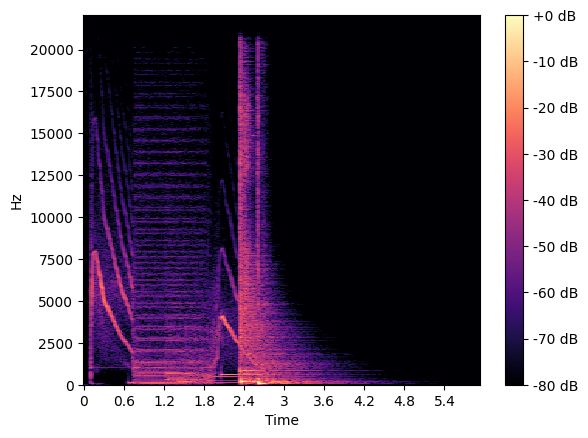

In [16]:
win_len = 4096 # FFT works best with powers of 2
n_fft = 4096
hop_len = 1024
anls_stft = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_len, win_length=win_len)
channels, n_anls_freqs, n_anls_frames = anls_stft.shape
print(anls_stft.shape)
show_sgram(anls_stft, hop_len, n_fft)